##  1. Title & Introduction
# Career Path Clustering  (Unsupervised Learning Project)
**Objective:**

To cluster resumes/job descriptions into career paths (e.g., Data Science, Web Development, Marketing)
using unsupervised learning (KMeans, PCA, t-SNE).

**Why this project?**
* Helps HR/placement cells in career guidance.
* Identifies required skills for different job roles.
* Provides role-based insights from resumes.


## 2. Theory Section

Theory: Unsupervised Learning & Model Tuning

- **Unsupervised Learning:** Learning patterns from unlabeled data.
- **Clustering (K-Means):** Divides data into K clusters by minimizing intra-cluster variance.
- **Hierarchical Clustering:** Builds nested clusters using bottom-up or top-down approach.
- **PCA (Principal Component Analysis):** Reduces dimensionality while retaining variance.
- **t-SNE:** Visualizes high-dimensional data in 2D/3D.
- **GridSearchCV:** Hyperparameter tuning using cross-validation.
- **Evaluation Metrics:** Silhouette Score, Davies-Bouldin Index.


## 3. Setup & Imports

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download NLTK data
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

## 4. Load Dataset

***Dataset***

We are using a dataset of resumes/job descriptions (`resume.csv`).
It contains raw resumes in text format.


In [2]:
from google.colab import files
uploaded = files.upload()
# Load dataset (Upload in Colab first)

df = pd.read_csv("resume.csv")
print(df.head())


Saving resume.csv to resume.csv
       Category                                             Resume
0  Data Science  Skills * Programming Languages: Python (pandas...
1  Data Science  Education Details \r\nMay 2013 to May 2017 B.E...
2  Data Science  Areas of Interest Deep Learning, Control Syste...
3  Data Science  Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4  Data Science  Education Details \r\n MCA   YMCAUST,  Faridab...


##  5.Exploratory Data Analysis (EDA)

Before applying clustering, it is important to understand the dataset.  
In this section, we will explore:

- Dataset shape and columns  
- Missing values check  
- Sample records for inspection  
- Most common keywords across resumes  
- WordCloud visualization of skills/keywords  

This helps us verify data quality and get insights into the text distribution before preprocessing.


Dataset shape: (962, 2)
Columns: ['Category', 'Resume']

Missing values per column:
Category    0
Resume      0
dtype: int64

Sample records:
       Category                                             Resume
0  Data Science  Skills * Programming Languages: Python (pandas...
1  Data Science  Education Details \r\nMay 2013 to May 2017 B.E...
2  Data Science  Areas of Interest Deep Learning, Control Syste...

Top 20 most common words:
and: 16713
the: 11495
for: 5255
exprience: 3829
with: 3804
company: 3568
project: 3498
months: 3288
description: 3122
details: 3096
data: 2152
management: 1979
team: 1946
maharashtra: 1449
system: 1425
testing: 1349
year: 1336
database: 1280
from: 1271
all: 1226


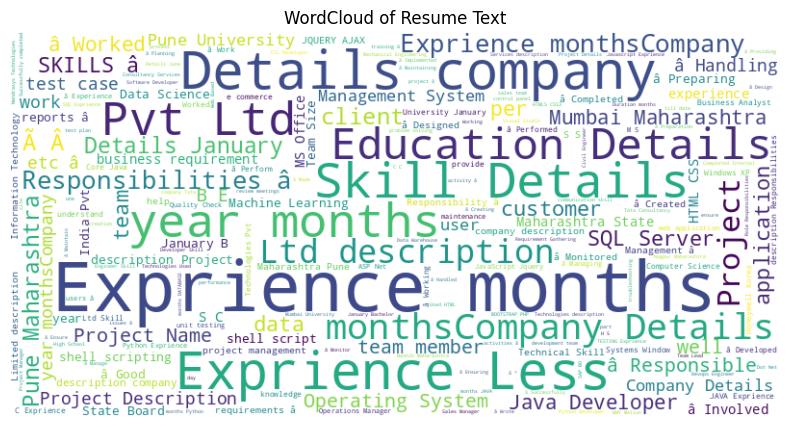

In [3]:

# 1. Dataset Overview
print("Dataset shape:", df.shape)
print("Columns:", df.columns.tolist())

# Null values check
print("\nMissing values per column:")
print(df.isnull().sum())

# Show sample resumes
print("\nSample records:")
print(df.head(3))

# 2. Word Frequency
from collections import Counter
import re

all_text = " ".join(df['Resume'].astype(str).tolist())
words = re.findall(r"\b[a-zA-Z]{3,}\b", all_text.lower())
common_words = Counter(words).most_common(20)

print("\nTop 20 most common words:")
for word, freq in common_words:
    print(f"{word}: {freq}")

# 3. WordCloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud of Resume Text")
plt.show()


Interactive Resume Length Distribution

In [4]:
# Interactive Histogram of Resume Lengths
import plotly.express as px

# Create a new column if not already present
if "Resume_Length" not in df.columns:
    df['Resume_Length'] = df['Resume'].apply(lambda x: len(str(x).split()))

fig = px.histogram(df, x="Resume_Length", nbins=30,
                   title="Interactive Distribution of Resume Lengths",
                   labels={"Resume_Length":"Number of words"},
                   color_discrete_sequence=['skyblue'])
fig.show()


Interactive Top Skills (Bar Chart)

In [5]:
# Interactive bar chart for top 15 most common words
skills, counts = zip(*common_words[:15])  # take top 15

fig = px.bar(x=skills, y=counts,
             labels={"x":"Skill/Word", "y":"Frequency"},
             title="Top 15 Most Frequent Words in Resumes",
             color=counts, color_continuous_scale="Oranges")
fig.update_layout(xaxis_tickangle=-45)
fig.show()


Interactive Treemap for Skills

In [6]:
# Treemap of top 15 words (alternative to WordCloud)
fig = px.treemap(names=skills, parents=[""]*len(skills), values=counts,
                 title="Interactive Treemap of Top Skills")
fig.show()


## 6. Preprocessing

Preprocessing
- Remove stopwords, special characters, numbers.
- Lemmatize words to root form.
- Store cleaned text in a new column.


In [7]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = re.sub(r"[^a-zA-Z ]", "", text)  # remove numbers/punctuations
    text = text.lower()
    words = text.split()
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]
    return " ".join(words)

df["cleaned_resume"] = df["Resume"].apply(clean_text)
print("Sample cleaned text:\n", df["cleaned_resume"].iloc[0])


Sample cleaned text:
 skill programming language python panda numpy scipy scikitlearn matplotlib sql java javascriptjquery machine learning regression svm nave bayes knn random forest decision tree boosting technique cluster analysis word embedding sentiment analysis natural language processing dimensionality reduction topic modelling lda nmf pca neural net database visualization mysql sqlserver cassandra hbase elasticsearch dj dcjs plotly kibana matplotlib ggplot tableau others regular expression html cs angular logstash kafka python flask git docker computer vision open cv understanding deep learningeducation detail data science assurance associate data science assurance associate ernst young llpskill detail javascript exprience monthsjquery exprience monthspython exprience monthscompany detail company ernst young llpdescription fraud investigation dispute service assurancetechnology assisted reviewtar technology assisted review assist accelerating review process run analytics genera

## 7. Feature Extraction

***Feature Extraction (TF-IDF)***
- Convert cleaned resumes into numerical vectors.
- Using TF-IDF (Term Frequency – Inverse Document Frequency).

In [8]:
vectorizer = TfidfVectorizer(max_features=2000)
X = vectorizer.fit_transform(df["cleaned_resume"]).toarray()
print("Vectorized shape:", X.shape)


Vectorized shape: (962, 2000)


## 8. Dimensionality Reduction
***Dimensionality Reduction***
- PCA reduces features for efficiency.
- t-SNE helps visualize clusters in 2D.

In [9]:
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X)

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_pca)


## 9.Elbow Method (to find optimal k)

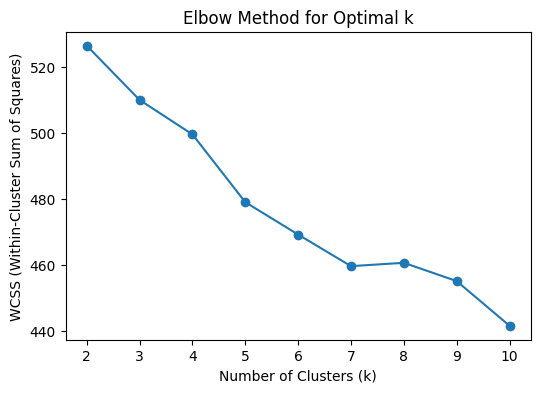

In [10]:
##  Optimal Number of Clusters (Elbow Method)

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

wcss = []
K = range(2, 11)
for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_pca)
    wcss.append(km.inertia_)

plt.figure(figsize=(6,4))
plt.plot(K, wcss, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("WCSS (Within-Cluster Sum of Squares)")
plt.title("Elbow Method for Optimal k")
plt.show()


## 10. Clustering

***Clustering***
- Apply KMeans clustering.
- Assign resumes into clusters.

In [11]:
k = 5  # Assume 5 clusters
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(X_pca)

df["Cluster"] = clusters


DBSCAN (Density-Based Spatial Clustering)

DBSCAN is good for text embeddings where clusters may not be perfectly spherical (like KMeans assumes).

In [12]:
from sklearn.cluster import DBSCAN

# Run DBSCAN on PCA-reduced data
dbscan = DBSCAN(eps=1.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_pca)

# Add to dataframe
df["DBSCAN_Cluster"] = dbscan_labels

print("Unique clusters from DBSCAN:", set(dbscan_labels))


Unique clusters from DBSCAN: {np.int64(0)}


Hierarchical Clustering (Agglomerative + Dendrogram)

Hierarchical clustering shows how clusters merge step by step.

Dendrograms are nice for visualization in reports/presentations.

In [13]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# Perform hierarchical clustering
Z = linkage(X_pca[:200], method='ward')  # use subset for speed

# Plot dendrogram
plt.figure(figsize=(100, 100))
dendrogram(Z, leaf_rotation=90, leaf_font_size=10)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Sample index")
plt.ylabel("Distance")
plt.show()


## 11. Evaluation
**11.a Silhouette Score checks how well clusters are formed.**

In [ ]:
sil_score = silhouette_score(X_pca, clusters)
print("Silhouette Score:", sil_score)


**11.b Additional Evaluation Metric (Davies–Bouldin Index)**

In [14]:
##  Additional Evaluation Metric (Davies-Bouldin Index)

from sklearn.metrics import davies_bouldin_score

dbi = davies_bouldin_score(X_pca, clusters)
print("Davies-Bouldin Index:", dbi)


Davies-Bouldin Index: 2.896124847090014


## 12. Visualization
- t-SNE scatterplot with cluster colors.
- Helps us see career path separation.

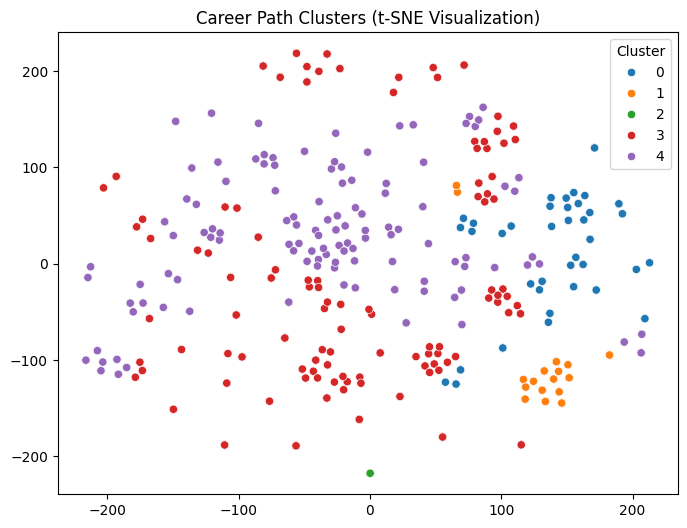

In [15]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=df["Cluster"], palette="tab10")
plt.title("Career Path Clusters (t-SNE Visualization)")
plt.show()


## 13. Insights

* Top keywords/skills in each cluster help us label career paths.

In [16]:
terms = vectorizer.get_feature_names_out()
for i in range(k):
    cluster_center = kmeans.cluster_centers_[i]
    top_terms = [terms[t] for t in cluster_center.argsort()[-10:]]
    print(f"\nCluster {i} Top Skills/Keywords: {top_terms}")



Cluster 0 Top Skills/Keywords: ['admin', 'according', 'administrator', 'acceptance', 'abstract', 'able', 'academic', 'ability', 'abacus', 'ab']

Cluster 1 Top Skills/Keywords: ['active', 'activity', 'administrative', 'ad', 'access', 'actual', 'accurately', 'account', 'able', 'abacus']

Cluster 2 Top Skills/Keywords: ['advanced', 'accepted', 'administrative', 'achievement', 'accept', 'accounting', 'accurately', 'abacus', 'acceptance', 'abstract']

Cluster 3 Top Skills/Keywords: ['achieve', 'accounting', 'added', 'according', 'able', 'accept', 'abstract', 'academic', 'ability', 'abacus']

Cluster 4 Top Skills/Keywords: ['actuator', 'accordance', 'administrative', 'accurate', 'achieved', 'accepted', 'academy', 'access', 'abap', 'ab']


## 14. Conclusion

- Resumes were clustered into career paths successfully.
- Identified skill sets for each career path.
- Model can assist HR teams in candidate classification.
- Future Work: Build a Streamlit app to upload resume and get predicted career

## 15.Project Summary Table

**Career Path Clustering – Project Summary**

| **Attribute**              | **Details** |
|-----------------------------|-------------|
| **Domain**                  | HRTech / Career Analytics |
| **Data Type**               | Resume text, job descriptions, skills, qualifications |
| **ML Techniques**           | TF-IDF, PCA, t-SNE, KMeans, Hierarchical Clustering |
| **Preprocessing Required**  | Text cleaning, stopword removal, lemmatization, vectorization, scaling |
| **Dimensionality Reduction**| PCA (retain variance), t-SNE (visualization) |
| **Clustering Method**       | KMeans (primary), Hierarchical (comparison) |
| **Evaluation Metrics**      | Silhouette Score, Davies-Bouldin Index |
| **Final Output**            | Role-based career clusters with top skill keywords |
| **Tools & Libraries**       | Python, Pandas, NumPy, Scikit-learn, NLTK, Matplotlib, Seaborn, Plotly |
